Enter coin or symbol (e.g., BTC/USDT or PEPE) [Enter=BTC/USDT]:  banana


Fetching OHLCV ...


17:36:52 | INFO | OHLCV: 1h BANANA/USDT@binance (1000 bars)


⏱️  OHLCV:   3.58s


17:37:18 | WARNING | Macro factor GOLD unavailable from Yahoo & FRED; skipping.


⏱️  Macro:  25.87s


17:37:25 | WARNING | Twitter bearer not set. Please export TWITTER_BEARER_TOKEN.


⏱️  Sentiment gather:   8.70s
⏱️  Sentiment resample:   0.01s
⏱️  Feature engineering:   0.01s
⏱️  KMeans regimes:   0.48s
⏱️  Phase labeling:   0.00s
⏱️  Spectral FFT:   0.00s
⏱️  Forecast simulation:   0.12s
⏱️  Projection + Decision:   0.01s


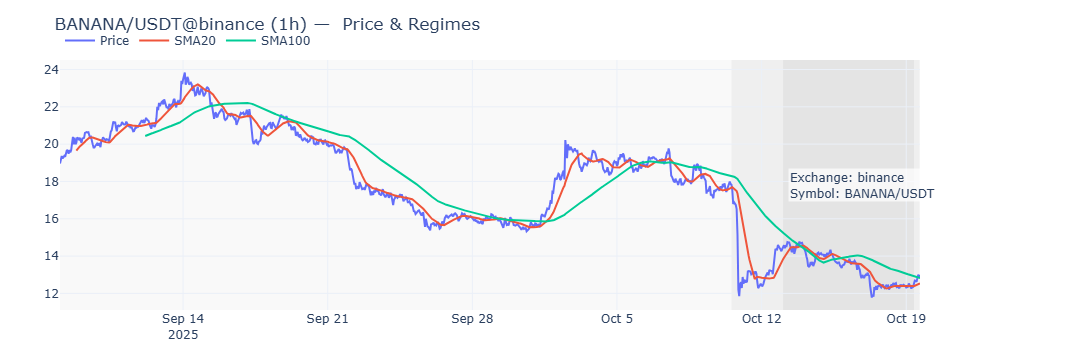

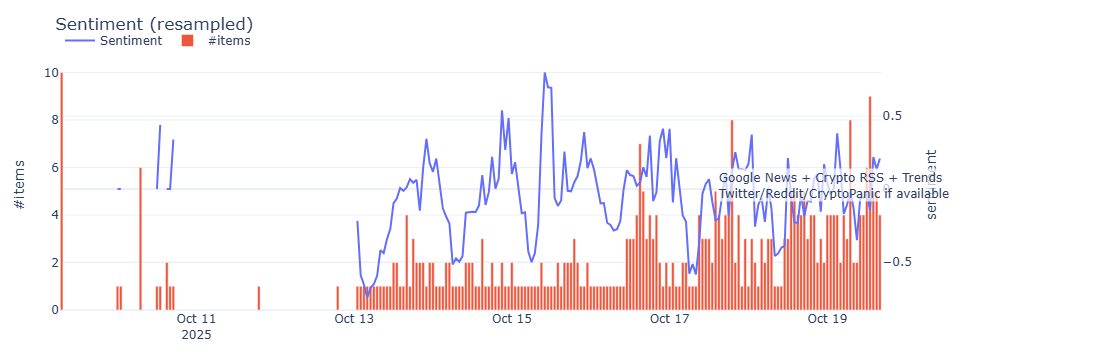

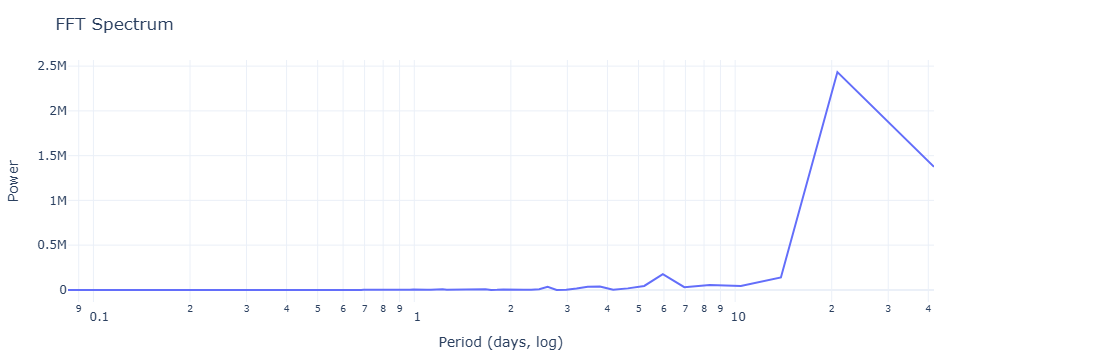

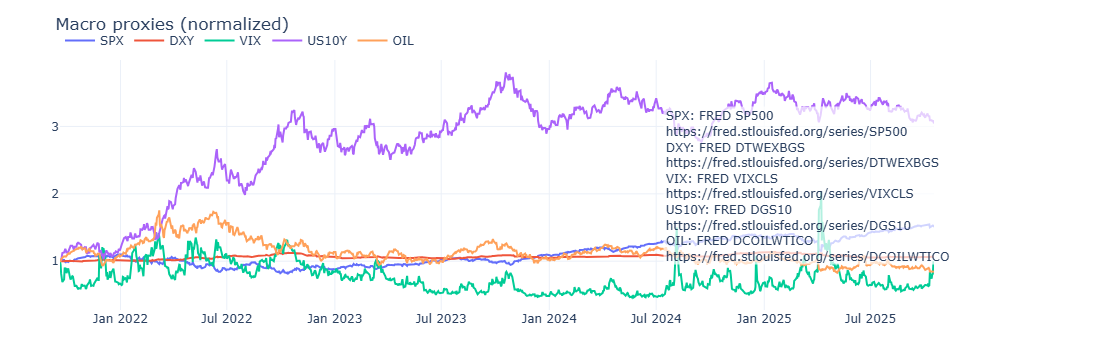

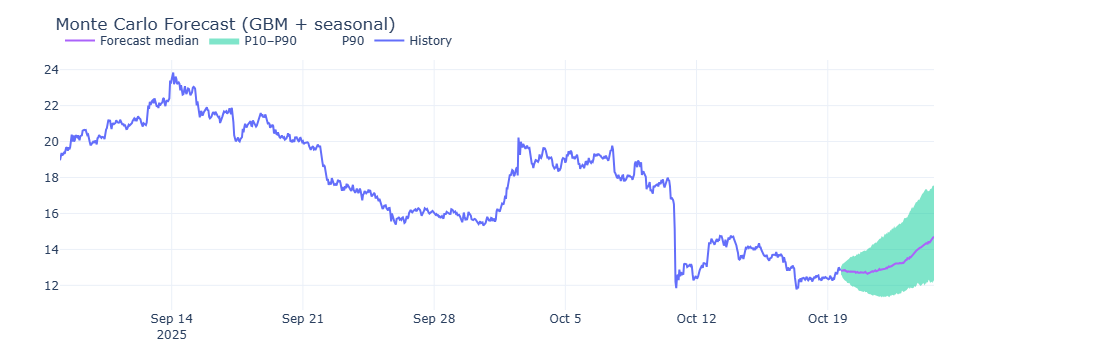

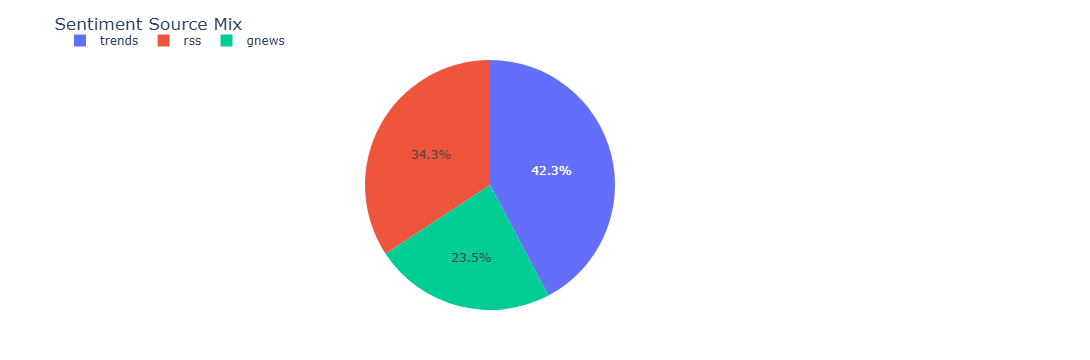

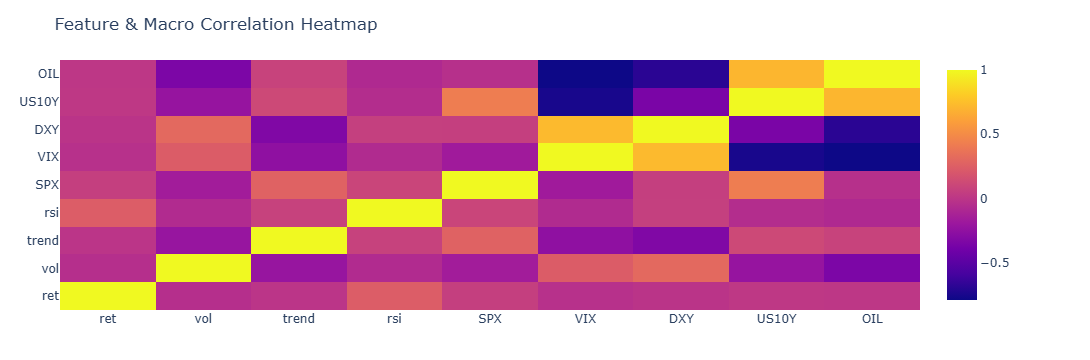

⏱️  Plotting:   0.70s

=== Market Lifecycle Summary ===
Symbol: BANANA/USDT  Exchange: binance  TF: 1h  Bars: 1000
Current regime: BULL  Phase: ACCUM
Dominant cycle lengths (days, approx): 20.8, 41.7, 6.0
Regime avg bars (history-based): {'bull_bars_mean': 1.5238095238095237, 'bear_bars_mean': 3.727272727272727}

=== Recommendation (explicit) ===
Action: HOLD | Position: FLAT | Confidence: 0.86
Rationale: trend=-0.022, rsi=64.4, sent50=-0.038, macro=-1.00, tf_min=60

Levels (risk controls):
LONG  -> entry=12.820000  SL=12.563600  TP=13.332800
SHORT -> entry=12.820000  SL=13.076400  TP=12.307200

Decision Criteria:
- LONG if: trend>0.005 & sentiment>0.05 & macro>=0
- SHORT if: trend<-0.005 & sentiment<-0.05 & macro<=0
- otherwise HOLD

=== Sources Used ===
OHLCV:
  Exchange: binance  Symbol: BANANA/USDT  Timeframe: 1h
Macro (per factor):
  - SPX: FRED → SP500  (https://fred.stlouisfed.org/series/SP500)
  - VIX: FRED → VIXCLS  (https://fred.stlouisfed.org/series/VIXCLS)
  - DXY: FRED → D

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Crypto Lifecycle + Sentiment + Macro (Yahoo+FRED) + Forecast + Executor
Low-latency native streaming + fully interactive Plotly charts.

Interactive:
- Hover tooltips on all charts (date / time / value).
- Forecast hover shows P10, P50, P90 together at the cursor point.
- Source URLs shown in a right-side panel (not over the lines).
Extras:
- Sentiment source pie chart
- Feature/Macro correlation heatmap

DISCLAIMER: Research/education only. Not investment advice.
"""
# SECURITY NOTE:
# Do NOT hardcode API keys, tokens, or exchange credentials in this file.
# Set them as environment variables (e.g. export TWITTER_BEARER_TOKEN=...) before running.
# Never commit real credentials to a public repo.

from __future__ import annotations
import os, sys, time, math, logging, argparse, warnings, json
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

os.environ.setdefault("OMP_NUM_THREADS", "4")
warnings.filterwarnings("ignore", category=FutureWarning)

# ---------- minimal installer ----------
def _pip_install(pkgs: list[str]):
    try:
        import subprocess, sys as _sys
        subprocess.check_call([_sys.executable, "-m", "pip", "install", "-U", *pkgs])
        return True
    except Exception:
        return False

def _ensure(mod, pip_name=None):
    try:
        return __import__(mod)
    except Exception:
        if pip_name and _pip_install([pip_name]):
            return __import__(mod)
        return None

# Core libs
import numpy as np
import pandas as pd

# Optional/live deps
ccxt        = _ensure("ccxt", "ccxt")
yfinance    = _ensure("yfinance", "yfinance")
pdr         = _ensure("pandas_datareader", "pandas_datareader")
feedparser  = _ensure("feedparser", "feedparser")
requests    = _ensure("requests", "requests")
praw        = _ensure("praw", "praw")
tweepy      = _ensure("tweepy", "tweepy")
pytrends    = _ensure("pytrends.request", "pytrends")
nltk        = _ensure("nltk", "nltk")
sklearn     = _ensure("sklearn", "scikit-learn")
plotly      = _ensure("plotly", "plotly")

from sklearn.cluster import KMeans
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sentiment (VADER)
from nltk.sentiment import SentimentIntensityAnalyzer
try:
    nltk.data.find("sentiment/vader_lexicon.zip")
except Exception:
    try: nltk.download("vader_lexicon", quiet=True)
    except Exception: pass
try:
    SIA = SentimentIntensityAnalyzer()
except Exception:
    SIA = None

# ---------- constants & env ----------
EX_ORDER = ["binance","bybit","kucoin","okx","kraken","gateio","bitget","mexc","bingx"]
PREF_QUOTES = ["USDT","USD","USDC","BTC","ETH"]

YF_MACRO = {
    "SPX":  ["^GSPC","^SPX","SPY"],
    "VIX":  ["^VIX"],
    "DXY":  ["DX=F","DX-Y.NYB","^DXY"],
    "US10Y":["^TNX"],
    "OIL":  ["CL=F","USO"],
    "GOLD": ["GC=F","GLD"],
}

FRED_MACRO = {
    "SPX":   "SP500",
    "VIX":   "VIXCLS",
    "DXY":   "DTWEXBGS",
    "US10Y": "DGS10",
    "OIL":   "DCOILWTICO",
    "GOLD":  "GOLDAMGBD228NLBM",
}

FRED_URL = "https://fred.stlouisfed.org/series/{}"
YF_URL   = "https://finance.yahoo.com/quote/{}"

CRYPTO_RSS = [
    "https://www.coindesk.com/arc/outboundfeeds/rss/",
    "https://cointelegraph.com/rss",
    "https://www.theblock.co/rss",
    "https://decrypt.co/feed",
    "https://bitcoinmagazine.com/.rss/full/",
    "https://cryptoslate.com/feed/",
    "https://ambcrypto.com/feed/",
    "https://www.newsbtc.com/feed/",
]

ENV = {
    "REDDIT_CLIENT_ID":     os.getenv("REDDIT_CLIENT_ID"),
    "REDDIT_CLIENT_SECRET": os.getenv("REDDIT_CLIENT_SECRET"),
    "REDDIT_USER_AGENT":    os.getenv("REDDIT_USER_AGENT","lifecycle-sentiment/1.0"),
    "TWITTER_BEARER_TOKEN": os.getenv("TWITTER_BEARER_TOKEN", "REPLACE_WITH_YOUR_TWITTER_BEARER"),
    "CRYPTOPANIC_TOKEN":    os.getenv("CRYPTOPANIC_TOKEN"),
}

FORCE_TWITTER = True  # try twitter if bearer set

# ---------- CLI ----------
@dataclass
class Args:
    symbol: str
    timeframe: str
    limit: int
    tz: str
    days_back_news: int
    reddit_days: int
    twitter_days: int
    twitter_limit: int
    trends_kw: Optional[str]
    loglevel: str
    no_macro: bool
    # Trading
    execute: bool
    paper: bool
    exchange: str
    api_key: Optional[str]
    api_secret: Optional[str]
    api_password: Optional[str]
    risk: float
    sl_pct: float
    tp_pct: float
    min_quote_balance: float
    max_slippage_pct: float
    # Forecast
    mc_paths: int
    mc_horizon_bars: int
    # Streaming
    stream_interval: float

def parse_args(argv: Optional[List[str]] = None) -> Args:
    p = argparse.ArgumentParser("Lifecycle+Sentiment+Forecast+Execute", add_help=True)
    p.add_argument("--symbol", default="BTC/USDT")
    p.add_argument("--timeframe", default="1h")
    p.add_argument("--limit", type=int, default=1000)
    p.add_argument("--tz", default="UTC")
    p.add_argument("--days-back-news", type=int, default=14)
    p.add_argument("--reddit-days", type=int, default=7)
    p.add_argument("--twitter-days", type=int, default=3)
    p.add_argument("--twitter-limit", type=int, default=400)
    p.add_argument("--trends-kw", default=None)
    p.add_argument("--no-macro", action="store_true")
    p.add_argument("--loglevel", default="INFO")
    # Trading
    p.add_argument("--execute", action="store_true")
    p.add_argument("--paper", action="store_true")
    p.add_argument("--live", dest="paper", action="store_false")
    p.add_argument("--exchange", default="binance")
    p.add_argument("--api-key", default=os.getenv("EXCHANGE_API_KEY"))
    p.add_argument("--api-secret", default=os.getenv("EXCHANGE_API_SECRET"))
    p.add_argument("--api-password", default=os.getenv("EXCHANGE_API_PASSWORD"))
    p.add_argument("--risk", type=float, default=0.02)
    p.add_argument("--sl-pct", type=float, default=0.02)
    p.add_argument("--tp-pct", type=float, default=0.04)
    p.add_argument("--min-quote-balance", type=float, default=25.0)
    p.add_argument("--max-slippage-pct", type=float, default=0.003)
    # Forecast
    p.add_argument("--mc-paths", type=int, default=300)
    p.add_argument("--mc-horizon-bars", type=int, default=120)
    # Streaming
    p.add_argument("--stream-interval", type=float, default=1.0, help="seconds between live ticks (native REST)")
    if argv is None: argv = sys.argv[1:]
    a, _unk = p.parse_known_args(argv)
    return Args(
        symbol=a.symbol, timeframe=str(a.timeframe).lower(), limit=a.limit, tz=a.tz,
        days_back_news=a.days_back_news, reddit_days=a.reddit_days,
        twitter_days=a.twitter_days, twitter_limit=a.twitter_limit, trends_kw=a.trends_kw,
        loglevel=a.loglevel, no_macro=a.no_macro,
        execute=a.execute, paper=a.paper, exchange=a.exchange,
        api_key=a.api_key, api_secret=a.api_secret, api_password=a.api_password,
        risk=a.risk, sl_pct=a.sl_pct, tp_pct=a.tp_pct,
        min_quote_balance=a.min_quote_balance, max_slippage_pct=a.max_slippage_pct,
        mc_paths=a.mc_paths, mc_horizon_bars=a.mc_horizon_bars,
        stream_interval=a.stream_interval
    )

def setup_logging(level="INFO"):
    logging.basicConfig(
        level=getattr(logging, level.upper(), logging.INFO),
        format="%(asctime)s | %(levelname)s | %(message)s",
        datefmt="%H:%M:%S",
    )
    logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# ---------- timers ----------
class T:
    def __init__(self): self.t0=time.perf_counter(); self.last=self.t0
    def tick(self, label): now=time.perf_counter(); print(f"⏱️  {label}: {now-self.last:6.2f}s"); self.last=now
    def total(self): print(f"⏱️  TOTAL: {time.perf_counter()-self.t0:6.2f}s")

# ---------- helpers ----------
def _split(sym:str)->Tuple[str,Optional[str]]:
    return (sym.split("/")[0].upper(), sym.split("/")[1].upper()) if "/" in sym else (sym.upper(), None)

# ---------- ccxt market ----------
def _build_ex(eid):
    if ccxt is None: raise RuntimeError("ccxt not installed.")
    return getattr(ccxt, eid)({"enableRateLimit": True})

def _find_mark(ex, base, quote)->Optional[str]:
    markets=ex.load_markets()
    if quote:
        s=f"{base}/{quote}"
        if s in markets: return s
        if quote=="USDT" and f"{base}/USD" in markets: return f"{base}/USD"
    for q in ([quote]+PREF_QUOTES if quote else PREF_QUOTES):
        if not q: continue
        s=f"{base}/{q}"
        if s in markets: return s
        if ex.id=="kraken" and base=="BTC" and f"XBT/{q}" in markets: return f"XBT/{q}"
    return None

def _closest_tf(ex, req:str)->str:
    m=getattr(ex, "timeframes", None)
    if not isinstance(m, dict) or not m: return req
    if req in m: return req
    pref=["1m","3m","5m","15m","30m","1h","2h","4h","6h","12h","1d"]
    if req in pref:
        choices=[tf for tf in pref if tf in m]
        if choices:
            return min(choices, key=lambda tf:abs(choices.index(tf)-pref.index(req)))
    return next(iter(m.keys()))

def fetch_ohlcv_any(symbol:str, tf:str, limit:int, tz:str)->pd.DataFrame:
    base, quote = _split(symbol)
    last_err=None
    for exid in EX_ORDER:
        try:
            ex=_build_ex(exid)
            sym=_find_mark(ex, base, quote)
            if not sym: continue
            tf2=_closest_tf(ex, tf)
            rows=ex.fetch_ohlcv(sym, timeframe=tf2, limit=limit)
            if not rows: continue
            df=pd.DataFrame(rows, columns=["ts","open","high","low","close","volume"])
            df["ts"]=pd.to_datetime(df["ts"],unit="ms",utc=True).dt.tz_convert(tz)
            df["exchange"]=exid; df["symbol"]=sym
            logging.info("OHLCV: %s %s@%s (%d bars)", tf2, sym, exid, len(df))
            return df
        except Exception as e:
            last_err=e; continue
    raise RuntimeError(f"All exchanges failed for {symbol}: {last_err}")

# ---------- macro (Yahoo primary, FRED secondary) ----------
def _yf_hist(sym:str, start, end):
    if yfinance is None: return None
    try:
        t=yfinance.Ticker(sym)
        df=t.history(start=start.date(), end=end.date(), auto_adjust=True)
        if df is None or df.empty: return None
        return df
    except Exception: return None

def _fred_hist(series_id:str, start, end):
    if pdr is None: return None
    try:
        import pandas_datareader.data as web
        df=web.DataReader(series_id,"fred", start=start.date(), end=end.date())
        if df is None or df.empty: return None
        df=df.rename(columns={series_id:"Close"})
        return df
    except Exception: return None

def fetch_macro(start:pd.Timestamp, end:pd.Timestamp, tz="UTC")->Tuple[pd.DataFrame, Dict[str, Dict[str,str]]]:
    cols={}; meta={}
    for factor, cands in YF_MACRO.items():
        got=None; used=None
        for sym in cands:  # Yahoo first
            df=_yf_hist(sym, start, end)
            if df is not None and not df.empty:
                got=df["Close"].rename(factor); used=("Yahoo", sym, YF_URL.format(sym)); break
        if got is None:    # FRED fallback
            fred_id = FRED_MACRO.get(factor)
            df2=_fred_hist(fred_id, start, end) if fred_id else None
            if df2 is not None and not df2.empty:
                got=df2["Close"].rename(factor); used=("FRED", fred_id, FRED_URL.format(fred_id))
        if got is not None:
            cols[factor]=got; meta[factor]={"source": used[0], "symbol": used[1], "url": used[2]}
        else:
            logging.warning("Macro factor %s unavailable from Yahoo & FRED; skipping.", factor)
    if not cols: return pd.DataFrame(), {}
    out=pd.concat(cols.values(), axis=1).sort_index().ffill()
    out.index=pd.to_datetime(out.index, utc=True).tz_convert(tz)
    return out, meta

# ---------- sentiment ----------
def _score_vader(rows:List[Tuple[pd.Timestamp,str,str]], tz:str)->pd.DataFrame:
    if not rows: return pd.DataFrame(columns=["ts","sentiment","text","source"])
    df=pd.DataFrame(rows, columns=["ts","text","source"])
    df["text"]=df["text"].astype(str).str.replace(r"http\S+|www\.\S+","",regex=True).str.slice(0,500)
    if SIA: df["sentiment"]=df["text"].apply(lambda x:SIA.polarity_scores(x)["compound"])
    else:   df["sentiment"]=0.0
    df["ts"]=pd.to_datetime(df["ts"], utc=True).dt.tz_convert(tz)
    return df

def sent_reddit(days:int, tz:str)->Optional[pd.DataFrame]:
    if not (praw and ENV["REDDIT_CLIENT_ID"] and ENV["REDDIT_CLIENT_SECRET"]): return None
    try:
        r=praw.Reddit(client_id=ENV["REDDIT_CLIENT_ID"], client_secret=ENV["REDDIT_CLIENT_SECRET"],
                      user_agent=ENV["REDDIT_USER_AGENT"], check_for_async=False)
        since=pd.Timestamp.now(tz="UTC")-pd.Timedelta(days=days)
        subs=["Bitcoin","CryptoCurrency","CryptoMarkets"]
        rows=[]
        for sub in subs:
            try:
                for s in r.subreddit(sub).new(limit=800):
                    ts=pd.Timestamp(s.created_utc, unit="s", tz="UTC")
                    if ts<since: continue
                    if getattr(s,"title",None): rows.append((ts, s.title, "reddit"))
                    if getattr(s,"selftext",None): rows.append((ts, s.selftext, "reddit"))
            except Exception: continue
        return _score_vader(rows, tz) if rows else None
    except Exception: return None

def sent_gnews(days:int, tz:str, query="bitcoin OR crypto")->Optional[pd.DataFrame]:
    if not feedparser: return None
    import urllib.parse as up
    try:
        url=f"https://news.google.com/rss/search?q={up.quote(query)}&hl=en-US&gl=US&ceid=US:en"
        feed=feedparser.parse(url)
        since=pd.Timestamp.now(tz="UTC")-pd.Timedelta(days=days)
        rows=[]
        for e in getattr(feed,"entries",[]):
            pp=getattr(e,"published_parsed",None)
            if not pp: continue
            ts=pd.Timestamp(*pp[:6], tz="UTC")
            if ts>=since: rows.append((ts, getattr(e,"title","") or "", "gnews"))
        df=_score_vader(rows, tz) if rows else None
        if df is not None: df.attrs={"gnews_url": url}
        return df
    except Exception: return None

def sent_rss(days:int, tz:str)->Optional[pd.DataFrame]:
    if not feedparser: return None
    since=pd.Timestamp.now(tz="UTC")-pd.Timedelta(days=days)
    rows=[]
    for url in CRYPTO_RSS:
        try:
            feed=feedparser.parse(url)
            for e in getattr(feed,"entries",[]):
                pp=getattr(e,"published_parsed",None)
                if not pp: continue
                ts=pd.Timestamp(*pp[:6], tz="UTC")
                if ts>=since: rows.append((ts, getattr(e,"title","") or "", "rss"))
        except Exception: continue
    return _score_vader(rows, tz) if rows else None

def sent_cryptopanic(days:int, tz:str, base:str)->Optional[pd.DataFrame]:
    if not (requests and ENV["CRYPTOPANIC_TOKEN"]): return None
    try:
        url="https://cryptopanic.com/api/v1/posts/"
        since=pd.Timestamp.now(tz="UTC")-pd.Timedelta(days=days)
        rows=[]
        params={"auth_token":ENV["CRYPTOPANIC_TOKEN"],"currencies":base.upper(),"kind":"news","regions":"en","public":"true","page":1}
        s=requests.Session()
        for _ in range(4):
            r=s.get(url, params=params, timeout=(10,20))
            if r.status_code==429:
                logging.warning("CryptoPanic rate limit; stopping early.")
                break
            if r.status_code!=200: break
            js=r.json()
            for post in js.get("results",[]):
                ts=pd.to_datetime(post.get("published_at"), utc=True, errors="coerce")
                if pd.isna(ts) or ts<since: continue
                title=(post.get("title") or "")+" "+(post.get("source",{}).get("title") or "")
                rows.append((ts, title.strip(), "cryptopanic"))
            if not js.get("next"): break
            params["page"]+=1
        df=_score_vader(rows, tz) if rows else None
        if df is not None: df.attrs={"cryptopanic_url": url}
        return df
    except Exception: return None

def sent_twitter(days:int, limit:int, tz:str, base:str)->Optional[pd.DataFrame]:
    if not FORCE_TWITTER: return None
    bearer=ENV["TWITTER_BEARER_TOKEN"]
    if not bearer or "REPLACE_WITH_YOUR_TWITTER_BEARER" in bearer:
        logging.warning("Twitter bearer not set. Please export TWITTER_BEARER_TOKEN.")
        return None
    if not tweepy: return None
    try:
        client=tweepy.Client(bearer_token=bearer, wait_on_rate_limit=True)
        end=pd.Timestamp.now(tz="UTC"); start=end-pd.Timedelta(days=days)
        q=f'({base} OR ${base} OR #{base} OR "{base.lower()} coin") lang:en -is:retweet'
        tweets=[]
        def _collect(page):
            if page and page.data:
                for t in page.data:
                    if getattr(t,"lang","en") not in (None,"en"): continue
                    tweets.append((pd.to_datetime(t.created_at, utc=True), t.text, "twitter"))
        first=client.search_recent_tweets(
            query=q, start_time=start.isoformat().replace("+00:00","Z"),
            end_time=end.isoformat().replace("+00:00","Z"),
            max_results=min(100,limit), tweet_fields=["created_at","lang"]
        )
        _collect(first)
        if limit>100 and first and getattr(first,"meta",None) and first.meta.get("next_token"):
            for page in tweepy.Paginator(
                client.search_recent_tweets, query=q,
                start_time=start.isoformat().replace("+00:00","Z"),
                end_time=end.isoformat().replace("+00:00","Z"),
                max_results=100, tweet_fields=["created_at","lang"]
            ):
                _collect(page)
                if len(tweets)>=limit: break
        df=_score_vader(tweets, tz) if tweets else None
        if df is not None: df.attrs={"twitter_query": q, "twitter_url": "https://api.twitter.com/2/tweets/search/recent"}
        return df
    except Exception as e:
        logging.warning("Twitter error: %s", e)
        return None

def sent_trends(tz:str, kw:str)->Optional[pd.DataFrame]:
    try:
        from pytrends.request import TrendReq
        pt=TrendReq(hl='en-US', tz=0)
        pt.build_payload([kw], timeframe='now 7-d', geo='')
        df=pt.interest_over_time()
        if df is None or df.empty: return None
        df=df.reset_index().rename(columns={"date":"ts", kw:"value"})
        df["ts"]=pd.to_datetime(df["ts"], utc=True).dt.tz_convert(tz)
        v=df["value"].astype(float)
        z=(v - v.rolling(60, min_periods=10).mean())/(v.rolling(60, min_periods=10).std()+1e-9)
        out=pd.DataFrame({"ts":df["ts"], "text":v.astype(str), "source":"trends", "sentiment":(z.clip(-3,3)/3.0)})
        out.attrs={"trends_kw": kw, "trends_url": "https://trends.google.com"}
        return out
    except Exception: return None

def gather_sentiment(base:str, args:Args)->Tuple[pd.DataFrame, Dict]:
    meta={"feeds": list(CRYPTO_RSS), "gnews_query": f'{base} OR "{base.lower()} coin"'}
    dfs=[]
    r=sent_reddit(args.reddit_days, args.tz)
    if r is not None and not r.empty: dfs.append(r)
    g=sent_gnews(args.days_back_news, args.tz, meta["gnews_query"])
    if g is not None and not g.empty: dfs.append(g); meta["gnews_url"]=g.attrs.get("gnews_url")
    rss=sent_rss(args.days_back_news, args.tz)
    if rss is not None and not rss.empty: dfs.append(rss)
    cp=sent_cryptopanic(args.days_back_news, args.tz, base)
    if cp is not None and not cp.empty: dfs.append(cp); meta["cryptopanic_url"]=cp.attrs.get("cryptopanic_url")
    tw=sent_twitter(args.twitter_days, args.twitter_limit, args.tz, base)
    if tw is not None and not tw.empty:
        dfs.append(tw); meta["twitter_query"]=tw.attrs.get("twitter_query"); meta["twitter_url"]=tw.attrs.get("twitter_url")
    tr=sent_trends(args.tz, (args.trends_kw or base.lower()))
    if tr is not None and not tr.empty:
        dfs.append(tr); meta["trends_kw"]=tr.attrs.get("trends_kw"); meta["trends_url"]=tr.attrs.get("trends_url")
    if not dfs:
        return pd.DataFrame(columns=["ts","sentiment","text","source"]), meta
    all_df=pd.concat(dfs, ignore_index=True).dropna(subset=["ts"]).sort_values("ts")
    return all_df, meta

# ---------- technicals & regimes ----------
def ta_rsi(series:pd.Series, n=14)->pd.Series:
    delta=series.diff()
    up=delta.clip(lower=0.0); dn=(-delta).clip(lower=0.0)
    roll_up=up.rolling(n).mean(); roll_dn=dn.rolling(n).mean()
    rs=roll_up/(roll_dn+1e-12)
    return 100 - (100/(1+rs))

def compute_features(df:pd.DataFrame)->pd.DataFrame:
    d=df.copy().sort_values("ts")
    d["ret"]=d["close"].pct_change()
    d["vol"]=d["ret"].rolling(20).std()
    d["sma_fast"]=d["close"].rolling(20).mean()
    d["sma_slow"]=d["close"].rolling(100).mean()
    d["trend"]=d["sma_fast"]/d["sma_slow"]-1
    d["rsi"]=ta_rsi(d["close"], 14)
    return d

def tf_to_rule(tf:str)->str:
    return {"1m":"1min","3m":"3min","5m":"5min","15m":"15min","30m":"30min","1h":"1h","2h":"2h","4h":"4h","6h":"6h","12h":"12h","1d":"1D"}.get(tf,"1h")

def make_sent_bars(sent:pd.DataFrame, rule:str)->pd.DataFrame:
    if sent is None or sent.empty:
        return pd.DataFrame(columns=["ts","sentiment","items"])
    s=sent.set_index("ts").sort_index()
    return pd.DataFrame({
        "sentiment": s["sentiment"].resample(rule).mean(),
        "items": s["sentiment"].resample(rule).count()
    }).reset_index()

def regime_clustering(d:pd.DataFrame, sent_bars:pd.DataFrame)->Tuple[pd.DataFrame,Dict]:
    x=d[["ret","vol","trend"]].copy()
    x["sent"] = pd.merge_asof(d[["ts"]], sent_bars[["ts","sentiment"]].sort_values("ts"), on="ts", direction="backward")["sentiment"].fillna(0.0) if sent_bars is not None and not sent_bars.empty else 0.0
    x=x.fillna(0.0)
    km=KMeans(n_clusters=3, n_init=10, random_state=42).fit(x.values)
    d=d.copy(); d["regime"]=km.labels_
    g=d.groupby("regime")[["trend","ret"]].mean().sort_values("trend")
    mapping={g.index[0]:"BEAR", g.index[1]:"CHOP", g.index[2]:"BULL"}
    d["regime_name"]=d["regime"].map(mapping)
    return d, mapping

def label_phases(d:pd.DataFrame)->pd.DataFrame:
    out=d.copy()
    out["phase"]="ACCUM"
    out.loc[(out["trend"]>0.01) & (out["vol"]<out["vol"].median()), "phase"]="MARKUP"
    out.loc[(out["trend"]< -0.01) & (out["vol"]>out["vol"].median()), "phase"]="MARKDOWN"
    out.loc[(out["trend"].abs()<=0.01), "phase"]="DISTRIB"
    return out

def spectral_cycles(series:pd.Series, fs_per_day:float)->Tuple[np.ndarray,np.ndarray]:
    x=series.dropna().values
    if len(x)<256:
        return np.array([]), np.array([])
    x = x - x.mean()
    spec=np.fft.rfft(x)
    freqs=np.fft.rfftfreq(len(x), d=1.0/fs_per_day)
    power=(spec*spec.conjugate()).real
    freqs=freqs[1:]; power=power[1:]
    periods_days=1.0/np.clip(freqs,1e-9,None)
    return periods_days, power

# ---------- forecast (GBM + seasonal) ----------
def forecast_mc(d:pd.DataFrame, bars:int, paths:int, tf_minutes:int, periods:np.ndarray, power:np.ndarray)->Tuple[np.ndarray,np.ndarray]:
    closes=d["close"].dropna().values
    if len(closes)<50: return np.arange(bars), np.tile(closes[-1], (paths, bars))
    rets=pd.Series(closes).pct_change().dropna()
    mu=float(rets.mean()); sig=float(rets.std())
    last=float(closes[-1])
    seasonal=np.zeros(bars)
    if len(periods)>0:
        i=int(np.argmax(power)); dom_days=float(periods[i])
        bars_per_day = max(1, int(1440/tf_minutes))
        per_bars = max(5, int(dom_days*bars_per_day))
        amp = 0.2*sig
        seasonal = amp*np.sin(2*np.pi*np.arange(bars)/per_bars)
    rng=np.random.default_rng(7); dt=1.0
    paths_out=np.zeros((paths, bars))
    for p in range(paths):
        price=last
        for t in range(bars):
            shock=rng.normal((mu-0.5*sig*sig)*dt, sig*np.sqrt(dt))
            price = max(1e-12, price * math.exp(shock + seasonal[t]))
            paths_out[p, t]=price
    return np.arange(1,bars+1), paths_out

# ---------- projection & recommendation ----------
def cycle_projection(d_labeled:pd.DataFrame)->Dict:
    reg=d_labeled.dropna(subset=["regime_name"]).copy()
    if reg.empty: return {"bull_bars_mean":None, "bear_bars_mean":None}
    reg["block"]= (reg["regime_name"]!=reg["regime_name"].shift()).cumsum()
    durations = reg.groupby(["block","regime_name"]).size().reset_index(name="bars")
    return {
        "bull_bars_mean": float(durations.query("regime_name=='BULL'")["bars"].mean() or np.nan),
        "bear_bars_mean": float(durations.query("regime_name=='BEAR'")["bars"].mean() or np.nan),
    }

def recommend(d:pd.DataFrame, sent_bars:pd.DataFrame, macro:pd.DataFrame, tf_minutes:int, args:Args)->Dict[str,str]:
    cur=d.iloc[-1]
    sent = float(sent_bars["sentiment"].tail(50).mean()) if sent_bars is not None and not sent_bars.empty else 0.0
    macro_score=0.0; macro_text=[]
    try:
        if macro is not None and not macro.empty:
            m=macro.copy()
            for col in ["SPX","DXY","VIX"]:
                if col in m.columns:
                    m[f"{col}_mom"]=m[col].pct_change(20)
            spx_up = m.get("SPX_mom", pd.Series([0])).iloc[-1] > 0
            dxy_up = m.get("DXY_mom", pd.Series([0])).iloc[-1] > 0
            vix_up = m.get("VIX_mom", pd.Series([0])).iloc[-1] > 0
            macro_score += (1 if spx_up else -1); macro_text.append(f"SPX {'↑' if spx_up else '↓'}")
            macro_score += (-1 if dxy_up else 1); macro_text.append(f"DXY {'↑' if dxy_up else '↓'} (↓ risk-on)")
            macro_score += (-1 if vix_up else 1); macro_text.append(f"VIX {'↑' if vix_up else '↓'} (↓ risk-on)")
            macro_score/=3.0
    except Exception: pass
    trend=float(cur.get("trend",0.0)); rsi=float(cur.get("rsi",50.0))
    long_ok  = (trend>0.005) and (sent>0.05) and (macro_score>=0)
    short_ok = (trend<-0.005) and (sent<-0.05) and (macro_score<=0)
    if long_ok and not short_ok: action, position = "BUY", "LONG"
    elif short_ok and not long_ok: action, position = "SELL", "SHORT"
    else: action, position = "HOLD", "FLAT"
    conf = 0.55 + 0.25*min(0.02, abs(trend))/0.02 + 0.15*min(0.10, abs(sent))/0.10 + 0.10*max(0,macro_score)
    conf = float(max(0.50, min(conf, 0.95)))
    price=float(cur["close"]); sl=args.sl_pct; tp=args.tp_pct
    long_entry=price;  long_sl=price*(1-sl); long_tp=price*(1+tp)
    short_entry=price; short_sl=price*(1+sl); short_tp=price*(1-tp)
    rationale=f"trend={trend:.3f}, rsi={rsi:.1f}, sent50={sent:.3f}, macro={macro_score:.2f}, tf_min={tf_minutes}"
    return {
        "action": action, "position": position, "confidence": f"{conf:.2f}",
        "rationale": rationale,
        "levels": {"long":{"entry":long_entry,"sl":long_sl,"tp":long_tp},
                   "short":{"entry":short_entry,"sl":short_sl,"tp":short_tp}}
    }

# ---------- Plotly helpers ----------
def _fig_layout(fig, title:str):
    fig.update_layout(
        title=title,
        hovermode="x",
        margin=dict(l=60, r=170, t=60, b=50),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
        template="plotly_white"
    )

def _annotate_side(fig, lines:List[str]):
    if not lines: return
    fig.add_annotation(
        x=1.02, y=0.5, xref="paper", yref="paper",
        text="<br>".join(lines),
        showarrow=False, align="left",
        bgcolor="rgba(255,255,255,0.7)"
    )

# ---------- Plotly charts ----------
def plot_all(ohlcv, d_feat, d_phase, sent_bars, macro, periods, power, macro_meta, title_prefix=""):
    # Price & regimes
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=ohlcv["ts"], y=ohlcv["close"], name="Price", mode="lines",
        hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>Price: %{y:.6f}<extra></extra>"
    ))
    if "sma_fast" in d_feat:
        fig.add_trace(go.Scatter(
            x=d_feat["ts"], y=d_feat["sma_fast"], name="SMA20", mode="lines",
            hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>SMA20: %{y:.6f}<extra></extra>"
        ))
    if "sma_slow" in d_feat:
        fig.add_trace(go.Scatter(
            x=d_feat["ts"], y=d_feat["sma_slow"], name="SMA100", mode="lines",
            hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>SMA100: %{y:.6f}<extra></extra>"
        ))

    # Regime shading
    if "regime_name" in d_feat.columns:
        lo=float(ohlcv["close"].min()); hi=float(ohlcv["close"].max())
        for name, opacity in [("BULL",0.08),("BEAR",0.10),("CHOP",0.05)]:
            m = d_feat["regime_name"]==name
            if m.any():
                xx = d_feat.loc[m, "ts"]
                fig.add_vrect(x0=xx.min(), x1=xx.max(),
                              fillcolor="gray", opacity=opacity, layer="below", line_width=0)

    _fig_layout(fig, f"{title_prefix} Price & Regimes")
    _annotate_side(fig, [f"Exchange: {ohlcv['exchange'].iloc[0]}",
                         f"Symbol: {ohlcv['symbol'].iloc[0]}"])
    fig.show()

    # Sentiment (resampled)
    if sent_bars is not None and not sent_bars.empty:
        fig2 = make_subplots(specs=[[{"secondary_y": True}]])
        fig2.add_trace(go.Scatter(
            x=sent_bars["ts"], y=sent_bars["sentiment"], name="Sentiment", mode="lines",
            hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>Sentiment: %{y:.3f}<extra></extra>"
        ), secondary_y=True)
        fig2.add_trace(go.Bar(
            x=sent_bars["ts"], y=sent_bars["items"], name="#items",
            hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>Items: %{y}<extra></extra>"
        ), secondary_y=False)
        fig2.update_yaxes(title_text="#items", secondary_y=False)
        fig2.update_yaxes(title_text="sentiment", secondary_y=True)
        _fig_layout(fig2, "Sentiment (resampled)")
        _annotate_side(fig2, ["Google News + Crypto RSS + Trends", "Twitter/Reddit/CryptoPanic if available"])
        fig2.show()

    # FFT spectrum
    if len(periods)>0:
        fig3 = go.Figure(go.Scatter(x=periods, y=power, mode="lines",
                     hovertemplate="Period: %{x:.2f} days<br>Power: %{y:.3g}<extra></extra>"))
        _fig_layout(fig3, "FFT Spectrum")
        fig3.update_xaxes(type="log", title="Period (days, log)")
        fig3.update_yaxes(title="Power")
        fig3.show()

    # Macro normalized
    if macro is not None and not macro.empty:
        fig4 = go.Figure()
        lines=[]
        for k in ["SPX","DXY","VIX","US10Y","OIL","GOLD"]:
            if k in macro.columns:
                base = float(macro[k].iloc[0])
                y = macro[k]/base if base else macro[k]
                fig4.add_trace(go.Scatter(
                    x=macro.index, y=y, name=k, mode="lines",
                    hovertemplate="%{x|%Y-%m-%d}<br>"+k+": %{y:.4f}<extra></extra>"
                ))
                meta=macro_meta.get(k)
                if meta:
                    lines.append(f"{k}: {meta['source']} {meta['symbol']}")
                    lines.append(meta['url'])
        _fig_layout(fig4, "Macro proxies (normalized)")
        _annotate_side(fig4, lines)
        fig4.show()

def plot_forecast(ohlcv:pd.DataFrame, t_axis:np.ndarray, paths:np.ndarray, tf_minutes:int):
    p10=np.percentile(paths,10,axis=0); p50=np.percentile(paths,50,axis=0); p90=np.percentile(paths,90,axis=0)
    last_ts=ohlcv["ts"].iloc[-1]
    future_ts = [last_ts + pd.Timedelta(minutes=int((i+1)*tf_minutes)) for i in range(len(t_axis))]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=ohlcv["ts"], y=ohlcv["close"], name="History", mode="lines",
        hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>Price: %{y:.6f}<extra></extra>"
    ))

    # Shaded band P10-P90: two traces with fill
    fig.add_trace(go.Scatter(
        x=future_ts, y=p90, name="P90", mode="lines", line=dict(width=0),
        hoverinfo="skip"
    ))
    fig.add_trace(go.Scatter(
        x=future_ts, y=p10, name="P10–P90", mode="lines", line=dict(width=0),
        fill="tonexty", hoverinfo="skip", showlegend=True
    ))

    # P50 with customdata so hover shows P10/P50/P90 together
    custom = np.column_stack([p10, p50, p90])
    fig.add_trace(go.Scatter(
        x=future_ts, y=p50, name="Forecast median", mode="lines",
        customdata=custom,
        hovertemplate=(
            "%{x|%Y-%m-%d %H:%M:%S}<br>"
            "P10: %{customdata[0]:.6f}<br>"
            "P50: %{customdata[1]:.6f}<br>"
            "P90: %{customdata[2]:.6f}<extra></extra>"
        )
    ))

    _fig_layout(fig, "Monte Carlo Forecast (GBM + seasonal)")
    fig.show()

def plot_pie_and_heatmap(sent_all:pd.DataFrame, macro:pd.DataFrame, d_feat:pd.DataFrame):
    # Pie: sentiment source mix
    if sent_all is not None and not sent_all.empty:
        counts = sent_all["source"].value_counts()
        fig = go.Figure(go.Pie(labels=counts.index.tolist(), values=counts.values.tolist(), hole=0.0))
        _fig_layout(fig, "Sentiment Source Mix")
        fig.show()

    # Heatmap: correlations
    cols_feat = [c for c in ["ret","vol","trend","rsi"] if c in d_feat.columns]
    parts=[]
    if cols_feat:
        df_feat = d_feat[cols_feat].copy()
        df_feat.index = pd.to_datetime(d_feat["ts"])
        parts.append(df_feat)
    if macro is not None and not macro.empty and cols_feat:
        parts.append(macro.reindex(df_feat.index, method="nearest", tolerance=pd.Timedelta("3D")))
    if not parts: return
    corr = pd.concat(parts, axis=1).dropna().corr()
    fig2 = go.Figure(data=go.Heatmap(z=corr.values, x=list(corr.columns), y=list(corr.index)))
    _fig_layout(fig2, "Feature & Macro Correlation Heatmap")
    fig2.show()

# ---------- trade executor ----------
class TradeExecutor:
    def __init__(self, args:Args, market_df:pd.DataFrame):
        self.args=args; self.market=market_df; self.exchange=None
        self.symbol=market_df["symbol"].iloc[-1]; self.exchange_id=market_df["exchange"].iloc[-1]
        self.entry_price=float(market_df["close"].iloc[-1])

    def _init_exchange(self):
        exid=self.args.exchange or self.exchange_id
        params={"enableRateLimit": True}
        if not self.args.paper:
            params.update({"apiKey": self.args.api_key or "", "secret": self.args.api_secret or "", "password": self.args.api_password or None})
        self.exchange=getattr(ccxt, exid)(params)

    def _fetch_balances(self)->Tuple[float, float, str]:
        markets=self.exchange.load_markets()
        base, quote = self.symbol.split("/")
        bal=self.exchange.fetch_balance()
        qbal=float(bal.get(quote,{}).get("free", 0.0) or 0.0)
        bbal=float(bal.get(base,{}).get("free", 0.0) or 0.0)
        return qbal, bbal, quote

    def _market_info(self)->Dict:
        m=self.exchange.market(self.symbol)
        return {
            "min_qty": float(m.get("limits",{}).get("amount",{}).get("min", 0.0) or 0.0),
            "min_notional": float(m.get("limits",{}).get("cost",{}).get("min", 0.0) or 0.0),
            "step": float(m.get("precision",{}).get("amount", 0.00000001) or 0.00000001),
            "price_step": float(m.get("precision",{}).get("price", 0.00000001) or 0.00000001),
        }

    def _round(self, qty, step):
        if step<=0: return qty
        return math.floor(qty/step)*step

    def preview(self, side:str)->Dict:
        sl=self.args.sl_pct; tp=self.args.tp_pct; entry=self.entry_price
        sl_price = entry * (1 - sl) if side=="buy" else entry * (1 + sl)
        tp_price = entry * (1 + tp) if side=="buy" else entry * (1 - tp)
        return {"side":side, "entry":entry, "sl":sl_price, "tp":tp_price}

    def execute(self, action:str)->Dict:
        if action not in ("BUY","SELL"): return {"status":"skipped", "reason":"HOLD decision"}
        side = "buy" if action=="BUY" else "sell"
        self._init_exchange(); sym=self.symbol
        qbal, bbal, quote = self._fetch_balances()
        if qbal < self.args.min_quote_balance and side=="buy" and not self.args.paper:
            return {"status":"failed", "reason":f"Insufficient {quote} balance (< {self.args.min_quote_balance})"}
        info=self._market_info(); entry=self.entry_price
        sl=self.args.sl_pct; tp=self.args.tp_pct
        sl_price = entry * (1 - sl) if side=="buy" else entry * (1 + sl)
        tp_price = entry * (1 + tp) if side=="buy" else entry * (1 - tp)
        quote_for_trade = (qbal if not self.args.paper else max(qbal, self.args.min_quote_balance)) * self.args.risk
        quote_for_trade = max(quote_for_trade, self.args.min_quote_balance*self.args.risk)
        qty = self._round(quote_for_trade / entry, info["step"])
        if info["min_qty"]>0 and qty < info["min_qty"]: qty = info["min_qty"]
        notional = qty * entry
        if info["min_notional"]>0 and notional < info["min_notional"]:
            qty = self._round(info["min_notional"]/entry, info["step"])
        plan = {"mode":"paper" if self.args.paper else "live","exchange": self.exchange.id,"symbol": sym,
                "side": side,"qty": float(qty),"entry": float(entry),"sl": float(sl_price),"tp": float(tp_price),
                "risk_frac": float(self.args.risk),"notional": float(qty*entry)}
        if self.args.paper:
            logging.info("[PAPER] %s", json.dumps(plan, indent=2)); return {"status":"paper", "plan":plan}
        ob=self.exchange.fetch_order_book(sym, limit=5)
        best=(ob["asks"][0][0] if side=="buy" else ob["bids"][0][0]); slip=abs(best/entry - 1.0)
        if slip > self.args.max_slippage_pct:
            return {"status":"failed", "reason":f"slippage {slip:.4f} > guard {self.args.max_slippage_pct:.4f}"}
        try:
            order=self.exchange.create_order(sym, "market", side, qty)
        except Exception as e:
            return {"status":"failed", "reason":f"entry order error: {e}", "plan":plan}
        plan["entry_order_id"]=order.get("id"); logging.info("[LIVE] %s", json.dumps(plan, indent=2))
        return {"status":"live", "plan":plan}

# ---------- NATIVE FAST-STREAM ----------
def _pair_flat(symbol_ccxt:str)->str:
    b,q = symbol_ccxt.split("/")
    return f"{b}{q}"

def _pair_dash(symbol_ccxt:str)->str:
    b,q = symbol_ccxt.split("/")
    return f"{b}-{q}"

def _native_quote(session, exchange_id:str, symbol_ccxt:str)->Optional[Dict]:
    if not requests: return None
    ex = exchange_id.lower()
    try:
        t0 = time.perf_counter()
        if ex=="binance":
            sym = _pair_flat(symbol_ccxt)
            url = f"https://api.binance.com/api/v3/ticker/24hr?symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json()
            last=float(d.get("lastPrice", d.get("weightedAvgPrice", 0.0)))
            bid=float(d.get("bidPrice", 0.0)); ask=float(d.get("askPrice", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="bybit":
            sym = _pair_flat(symbol_ccxt)
            url = f"https://api.bybit.com/v5/market/tickers?category=spot&symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json()
            lst=d.get("result",{}).get("list",[{}])[0]
            last=float(lst.get("lastPrice", 0.0)); bid=float(lst.get("bid1Price", 0.0)); ask=float(lst.get("ask1Price", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="kucoin":
            sym = _pair_dash(symbol_ccxt)
            url = f"https://api.kucoin.com/api/v1/market/orderbook/level1?symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json().get("data",{})
            last=float(d.get("price", 0.0)); bid=float(d.get("bestBid", 0.0)); ask=float(d.get("bestAsk", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="okx":
            sym = _pair_dash(symbol_ccxt)
            url = f"https://www.okx.com/api/v5/market/ticker?instId={sym}"
            arr=session.get(url, timeout=(1.2, 2.0)).json().get("data",[])
            d=arr[0] if arr else {}
            last=float(d.get("last", 0.0)); bid=float(d.get("bidPx", 0.0)); ask=float(d.get("askPx", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="kraken":
            b,q = symbol_ccxt.split("/"); b2 = "XBT" if b=="BTC" else b
            pair = f"{b2}{q}"; url = f"https://api.kraken.com/0/public/Ticker?pair={pair}"
            res=session.get(url, timeout=(1.2, 2.0)).json().get("result",{})
            if res:
                k=list(res.keys())[0]; d=res[k]
                last=float(d["c"][0]); bid=float(d["b"][0]); ask=float(d["a"][0])
                return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="gateio":
            sym = _pair_dash(symbol_ccxt)
            url = f"https://api.gateio.ws/api/v4/spot/tickers?currency_pair={sym}"
            r=session.get(url, timeout=(1.2, 2.0)).json()
            d=r[0] if r else {}
            last=float(d.get("last", 0.0)); bid=float(d.get("highest_bid", 0.0)); ask=float(d.get("lowest_ask", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="bitget":
            sym = _pair_dash(symbol_ccxt)
            url = f"https://api.bitget.com/api/spot/v1/market/ticker?symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json().get("data",{})
            last=float(d.get("close", 0.0)); bid=float(d.get("bestBid", 0.0)); ask=float(d.get("bestAsk", 0.0))
            if not last and bid and ask: last=(bid+ask)/2.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="mexc":
            sym = _pair_flat(symbol_ccxt)
            url = f"https://api.mexc.com/api/v3/ticker/bookTicker?symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json()
            bid=float(d.get("bidPrice", 0.0)); ask=float(d.get("askPrice", 0.0))
            last=(bid+ask)/2.0 if (bid and ask) else 0.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
        if ex=="bingx":
            sym = _pair_flat(symbol_ccxt)
            url = f"https://open-api.bingx.com/openApi/spot/v1/ticker/bookTicker?symbol={sym}"
            d=session.get(url, timeout=(1.2, 2.0)).json().get("data",{})
            bid=float(d.get("bidPrice", 0.0)); ask=float(d.get("askPrice", 0.0))
            last=(bid+ask)/2.0 if (bid and ask) else 0.0
            return {"last":last,"bid":bid,"ask":ask,"ts_recv":time.perf_counter(),"src":url, "t0":t0}
    except Exception:
        return None
    return None

def stream_native(exchange_id:str, symbol_ccxt:str, interval_sec:float=1.0):
    if not requests:
        print("requests not available; cannot stream natively.")
        return
    sess = requests.Session()
    adapter = requests.adapters.HTTPAdapter(pool_connections=4, pool_maxsize=8, max_retries=0)
    sess.mount("https://", adapter); sess.mount("http://", adapter)
    print("Streaming (native REST fast-path; Ctrl+C to stop)...")
    while True:
        loop_start = time.perf_counter()
        try:
            q=_native_quote(sess, exchange_id, symbol_ccxt)
            if q is None:
                ex=_build_ex(exchange_id)
                t=ex.fetch_ticker(symbol_ccxt)
                last=t.get("last"); bid=t.get("bid"); ask=t.get("ask")
                recv = time.perf_counter()
                latency = recv - loop_start
                print(f"{symbol_ccxt} last={last} bid={bid} ask={ask}  latency={latency*1000:.0f}ms  src=ccxt")
            else:
                recv = q["ts_recv"]; latency = recv - q.get("t0", recv)
                print(f"{symbol_ccxt} last={q['last']} bid={q['bid']} ask={q['ask']}  latency={latency*1000:.0f}ms  src={q['src']}")
            elapsed = time.perf_counter() - loop_start
            time.sleep(max(0.0, interval_sec - elapsed))
        except KeyboardInterrupt:
            print("Stopped streaming."); break
        except Exception as e:
            print("Stream error:", e); time.sleep(interval_sec)

# ---------- main ----------
def main(argv: Optional[List[str]] = None):
    args = parse_args(argv)
    setup_logging(args.loglevel)
    timer = T()

    print("Fetching OHLCV ...")
    ohlcv = fetch_ohlcv_any(args.symbol, args.timeframe, args.limit, args.tz)
    timer.tick("OHLCV")

    macro = pd.DataFrame(); macro_meta={}
    if not args.no_macro:
        start = (pd.Timestamp.now(tz="UTC") - pd.Timedelta(days=365*4+30)).tz_convert("UTC")
        end   = pd.Timestamp.now(tz="UTC") + pd.Timedelta(days=1)
        macro, macro_meta = fetch_macro(start, end, args.tz)
    timer.tick("Macro")

    base = ohlcv["symbol"].iloc[0].split("/")[0]
    sent_all, sent_meta = gather_sentiment(base, args)
    timer.tick("Sentiment gather")

    rule = tf_to_rule(args.timeframe)
    sent_bars = make_sent_bars(sent_all, rule)
    timer.tick("Sentiment resample")

    d = ohlcv[["ts","open","high","low","close","volume","symbol","exchange"]].copy()
    d_feat = compute_features(d)
    timer.tick("Feature engineering")

    d_feat2, mapping = regime_clustering(d_feat, sent_bars)
    timer.tick("KMeans regimes")

    d_phase = label_phases(d_feat2)
    timer.tick("Phase labeling")

    tf_map={"1m":1440,"3m":480,"5m":288,"15m":96,"30m":48,"1h":24,"2h":12,"4h":6,"6h":4,"12h":2,"1d":1}
    fs = tf_map.get(args.timeframe, 24)
    periods, power = spectral_cycles(d_feat["close"], fs_per_day=fs)
    timer.tick("Spectral FFT")

    tf_minutes = {"1m":1,"3m":3,"5m":5,"15m":15,"30m":30,"1h":60,"2h":120,"4h":240,"6h":360,"12h":720,"1d":1440}.get(args.timeframe,60)
    t_axis, paths = forecast_mc(d_feat2, args.mc_horizon_bars, args.mc_paths, tf_minutes, periods, power)
    timer.tick("Forecast simulation")

    proj = cycle_projection(d_phase)
    rec  = recommend(d_phase, sent_bars, macro, tf_minutes, args)
    timer.tick("Projection + Decision")

    title_prefix=f"{d['symbol'].iloc[0]}@{d['exchange'].iloc[0]} ({args.timeframe}) — "
    plot_all(ohlcv, d_feat2, d_phase, sent_bars, macro, periods, power, macro_meta, title_prefix=title_prefix)
    plot_forecast(ohlcv, t_axis, paths, tf_minutes)
    plot_pie_and_heatmap(sent_all, macro, d_feat2)
    timer.tick("Plotting")

    print("\n=== Market Lifecycle Summary ===")
    print(f"Symbol: {d['symbol'].iloc[0]}  Exchange: {d['exchange'].iloc[0]}  TF: {args.timeframe}  Bars: {len(d)}")
    print(f"Current regime: {d_phase['regime_name'].iloc[-1]}  Phase: {d_phase['phase'].iloc[-1]}")
    if len(periods)>0:
        top_idx = np.argsort(power)[-3:][::-1]
        top_periods = [float(periods[i]) for i in top_idx]
        print(f"Dominant cycle lengths (days, approx): {', '.join(f'{p:.1f}' for p in top_periods)}")
    print("Regime avg bars (history-based):", proj)

    print("\n=== Recommendation (explicit) ===")
    print(f"Action: {rec['action']} | Position: {rec['position']} | Confidence: {rec['confidence']}")
    print(f"Rationale: {rec['rationale']}")
    lv=rec["levels"]
    print("\nLevels (risk controls):")
    print(f"LONG  -> entry={lv['long']['entry']:.6f}  SL={lv['long']['sl']:.6f}  TP={lv['long']['tp']:.6f}")
    print(f"SHORT -> entry={lv['short']['entry']:.6f}  SL={lv['short']['sl']:.6f}  TP={lv['short']['tp']:.6f}")
    print("\nDecision Criteria:")
    print("- LONG if: trend>0.005 & sentiment>0.05 & macro>=0")
    print("- SHORT if: trend<-0.005 & sentiment<-0.05 & macro<=0")
    print("- otherwise HOLD")

    print("\n=== Sources Used ===")
    print("OHLCV:")
    print(f"  Exchange: {d['exchange'].iloc[0]}  Symbol: {d['symbol'].iloc[0]}  Timeframe: {args.timeframe}")
    if macro_meta:
        print("Macro (per factor):")
        for k,v in macro_meta.items():
            print(f"  - {k}: {v['source']} → {v['symbol']}  ({v['url']})")
    else:
        print("Macro: none (disabled or unavailable)")
    print("Sentiment:")
    if "twitter_query" in sent_meta:
        print(f"  - Twitter: {sent_meta['twitter_query']}  ({sent_meta.get('twitter_url','')})")
    else:
        print("  - Twitter: not used or unavailable")
    print(f"  - Google News: {sent_meta.get('gnews_query','')}  ({sent_meta.get('gnews_url','')})")
    if "trends_kw" in sent_meta: print(f"  - Google Trends: kw={sent_meta['trends_kw']}  ({sent_meta.get('trends_url','')})")
    if sent_meta.get("cryptopanic_url"): print(f"  - CryptoPanic API: {sent_meta['cryptopanic_url']}")
    print("  - Crypto RSS feeds:")
    for url in sent_meta.get("feeds", []): print(f"    * {url}")
    if ENV["REDDIT_CLIENT_ID"]: print("  - Reddit (Bitcoin/Crypto subs)")
    if not sent_all.empty:
        print(f"Counts by source: {sent_all['source'].value_counts().to_dict()}")

    if args.execute:
        try:
            ex = TradeExecutor(args, d)
            print("\nExecution Preview:", json.dumps(ex.preview("buy" if rec["action"]=="BUY" else "sell"), indent=2))
            result = ex.execute(rec["action"])
            print("Execution Result:", json.dumps(result, indent=2))
        except Exception as e:
            logging.error("Execution error: %s", e)

    try:
        choice = input("\nEnable LIVE trade execution now? (y/N): ").strip().lower()
        if choice == "y":
            args.execute=True; args.paper=False
            try:
                ex = TradeExecutor(args, d)
                print("Live Preview:", json.dumps(ex.preview("buy" if rec["action"]=="BUY" else "sell"), indent=2))
                ok = input(f"Send {rec['action']} market order? (y/N): ").strip().lower()=="y"
                if ok:
                    result = ex.execute(rec["action"])
                    print("Live Execution Result:", json.dumps(result, indent=2))
                else:
                    print("Live order canceled.")
            except Exception as e:
                logging.error("Live execution error: %s", e)
        stream = input(f"Enable basic price streaming via native REST every {args.stream_interval:.1f}s? (y/N): ").strip().lower()
        if stream=="y":
            exid=d["exchange"].iloc[0]; sym=d["symbol"].iloc[0]
            stream_native(exid, sym, args.stream_interval)
    except Exception:
        pass

    timer.total()

# ---------- entry ----------
if __name__ == "__main__":
    try:
        coin = input("Enter coin or symbol (e.g., BTC/USDT or PEPE) [Enter=BTC/USDT]: ").strip()
    except Exception:
        coin = ""
    argv = []
    if coin: argv += ["--symbol", coin]
    main(argv)
